### Airline Data Analysis_RF_DEP_DELAY:
Can we predict departure delays using features in the data ? Let us find out.

In [1]:
PATH='/Users/franciumpnc/Documents/ML/AQM/ML_practice_projects/Airline_data_analysis/data/processed'

In [2]:
!ls {PATH}

Airline_data_processed.csv


In [3]:
import feather
import pandas as pd
import matplotlib.pyplot as plt
import re
from helper.imports import *
from helper.structured  import *
%matplotlib inline

/Applications/anaconda3/envs/DNN/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
data_raw = pd.read_feather(f'{PATH}/Airline_data_processed.csv')

In [5]:
data_raw.columns

Index(['index', 'OP_UNIQUE_CARRIER', 'DEP_DELAY2', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'FLIGHTS', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'FL_DATEYear', 'FL_DATEMonth',
       'FL_DATEWeek', 'FL_DATEDay', 'FL_DATEDayofweek', 'FL_DATEDayofyear',
       'FL_DATEIs_month_end', 'FL_DATEIs_month_start', 'FL_DATEIs_quarter_end',
       'FL_DATEIs_quarter_start', 'FL_DATEIs_year_end', 'FL_DATEIs_year_start',
       'FL_DATEElapsed', 'Description', 'Unnamed: 0', 'formatted_address',
       'latitude', 'longitude', 'accuracy', 'google_place_id', 'type',
       'postcode', 'Address', 'number_of_results', 'status'],
      dtype='object')

In [6]:
data = data_raw[['OP_UNIQUE_CARRIER','ORIGIN',
       'DEST_AIRPORT_ID', 'CRS_DEP_TIME',
       'DEP_DELAY','FLIGHTS', 'DISTANCE',
       'FL_DATEYear', 'FL_DATEMonth',
       'FL_DATEWeek', 'FL_DATEDay', 'FL_DATEDayofweek', 'FL_DATEDayofyear',
       'FL_DATEIs_month_end', 'FL_DATEIs_month_start', 'FL_DATEIs_quarter_end',
       'FL_DATEIs_quarter_start', 'FL_DATEIs_year_end', 'FL_DATEIs_year_start',
       'FL_DATEElapsed','latitude', 'longitude']]

#### Before running Random Forest

- Convert strings in dataframe to categorical. This is done by applying train_cats.
- Convert the entire dataframe into numeric dataframe. Replace the na values by median value of the column. This is done by proc_df. This also splits off the response variable. 

In [7]:
train_cats(data)

/Users/franciumpnc/Documents/ML/AQM/ML_practice_projects/Airline_data_analysis/notebooks/helper/structured.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()


In [8]:
df, y, nas = proc_df(data, 'DEP_DELAY')

In [9]:
df.head()

OP_UNIQUE_CARRIER  ORIGIN  DEST_AIRPORT_ID  CRS_DEP_TIME  FLIGHTS  \
0                 15      93            11292          1430      1.0   
1                 15      93            11292          1155      1.0   
2                 15      93            12889           600      1.0   
3                 15      93            12953          1545      1.0   
4                 15      93            12953           600      1.0   

   DISTANCE  FL_DATEYear  FL_DATEMonth  FL_DATEWeek  FL_DATEDay  ...  \
0     896.0         2020             1            1           1  ...   
1     896.0         2020             1            1           1  ...   
2    1524.0         2020             1            1           1  ...   
3     738.0         2020             1            1           1  ...   
4     738.0         2020             1            1           1  ...   

   FL_DATEDayofyear  FL_DATEIs_month_end  FL_DATEIs_month_start  \
0                 1                False                   True   
1                 1                False                   True   
2                 1                False                   True   
3                 1                False                   True   
4                 1                False                   True   

   FL_DATEIs_quarter_end  FL_DATEIs_quarter_start  FL_DATEIs_year_end  \
0                  False                     True               False   
1                  False                     True               False   
2                  False                     True               False   
3                  False                     True               False   
4                  False                     True               False   

   FL_DATEIs_year_start  FL_DATEElapsed   latitude  longitude  
0                  True      1577836800  42.947553 -87.896646  
1                  True      1577836800  42.947553 -87.896646  
2                  True      1577836800  42.947553 -87.896646  
3                  True      1577836800  42.947553 -87.896646  
4                  True      1577836800  42.947553 -87.896646  

[5 rows x 21 columns]

In [10]:
#First test on a small part of the data
dftest = df
ytest=y

In [11]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12  # 
n_trn = len(dftest)-n_valid
raw_train, raw_valid = split_vals(dftest, n_trn)
X_train, X_valid = split_vals(dftest, n_trn)
y_train, y_valid = split_vals(ytest, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((558157, 21), (558157,), (12, 21))

In [12]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [13]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn.model_selection import cross_val_score

from sklearn import metrics
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9min 25s, sys: 6.41 s, total: 9min 32s
Wall time: 2min 42s
[11.465799025280106, 18.649095599161548, 0.8606167671737288, 0.30967659480619736]


In [14]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3min 25s, sys: 1.52 s, total: 3min 26s
Wall time: 1min
[21.176006031790852, 20.10975965086446, 0.5245662730796785, 0.1973045379192091, 0.052927430542585086]


In [15]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 35s, sys: 724 ms, total: 1min 36s
Wall time: 29.3 s
[26.18829584129751, 23.275187193300802, 0.27286280627974246, -0.07528456744748158, 0.09055832391906082]


In [16]:
ntrees = 100
minleaf = 1
for maxf in np.arange(0.1,0.6,0.1):
    print(f"n_estimators={ntrees}, max_features={maxf:.1f}, min_samples_leaf={minleaf}")
    m = RandomForestRegressor(n_estimators=ntrees, min_samples_leaf=minleaf, max_features=maxf, n_jobs=-1,\
                              oob_score=True)
    %time m.fit(X_train, y_train)
    print_score(m)
    print('----------')

n_estimators=100, max_features=0.1, min_samples_leaf=1
CPU times: user 2min 19s, sys: 5.06 s, total: 2min 24s
Wall time: 49.7 s
[11.212950851217542, 17.568897707786526, 0.86669644850222, 0.3873307603241991, 0.03083434457298251]
----------
n_estimators=100, max_features=0.2, min_samples_leaf=1
CPU times: user 2min 40s, sys: 4.83 s, total: 2min 44s
Wall time: 53.6 s
[11.212548824863676, 16.467649093500462, 0.8667060071956895, 0.46172990020400295, 0.03239000867252906]
----------
n_estimators=100, max_features=0.3, min_samples_leaf=1
CPU times: user 3min 21s, sys: 4.95 s, total: 3min 26s
Wall time: 1min 5s
[11.21569674608727, 16.46518650567514, 0.8666311521566338, 0.4618908750068921, 0.03269526679713275]
----------
n_estimators=100, max_features=0.4, min_samples_leaf=1
CPU times: user 4min 5s, sys: 5.28 s, total: 4min 10s
Wall time: 1min 22s
[11.24430891572772, 17.765265735886604, 0.8659498142752879, 0.3735585819043945, 0.0276515502722251]
----------
n_estimators=100, max_features=0.5, min

In [17]:
# choose max_feature = 0.2
ntrees = 100
#minleaf = 1
maxf = 0.2
for minleaf in range(1,7):
    print(f"n_estimators={ntrees}, max_features={maxf:.1f}, min_samples_leaf={minleaf}")
    m = RandomForestRegressor(n_estimators=ntrees, min_samples_leaf=minleaf, max_features=0.2, n_jobs=-1,\
                              oob_score=True)
    %time m.fit(X_train, y_train)
    print_score(m)
    print('----------')

n_estimators=100, max_features=0.2, min_samples_leaf=1
CPU times: user 2min 42s, sys: 4.78 s, total: 2min 47s
Wall time: 54.7 s
[11.195894669802883, 17.256658376792807, 0.8671016799791305, 0.40891430225505876, 0.03511692377059106]
----------
n_estimators=100, max_features=0.2, min_samples_leaf=2
CPU times: user 2min 21s, sys: 2.69 s, total: 2min 24s
Wall time: 46.7 s
[20.319502872216805, 19.27254279027808, 0.5622480997517102, 0.26274948438487145, 0.07864457392723889]
----------
n_estimators=100, max_features=0.2, min_samples_leaf=3
CPU times: user 2min 15s, sys: 2.03 s, total: 2min 17s
Wall time: 44.1 s
[22.935467899491442, 18.93270635469574, 0.442278878559621, 0.2885204103835852, 0.08836329799990883]
----------
n_estimators=100, max_features=0.2, min_samples_leaf=4
CPU times: user 2min 9s, sys: 1.66 s, total: 2min 11s
Wall time: 41.9 s
[24.240070861260495, 20.481983587559547, 0.3770263850964499, 0.1673143595678387, 0.09173129561342919]
----------
n_estimators=100, max_features=0.2, mi

In [18]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [19]:
m = RandomForestRegressor(n_estimators=ntrees, min_samples_leaf=1, max_features=0.2, n_jobs=-1,\
                              oob_score=True)
clf=m.fit(X_train, y_train)

/Applications/anaconda3/envs/DNN/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


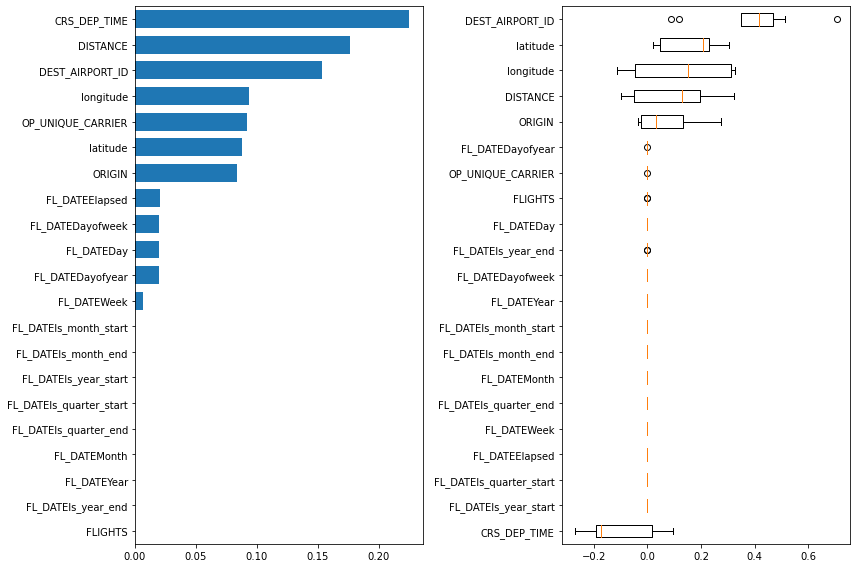

In [20]:
result = permutation_importance(m, X_valid, y_valid, n_repeats=10,random_state=0)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

In [21]:
perm_sorted_idx 

array([ 3, 17, 15, 18,  8, 14,  7, 12, 13,  6, 10, 16,  9,  4,  0, 11,  1,  5, 20, 19,  2])

In [22]:
min_samples_leaf = 3
ntrees = 100
max_features=0.2


def test_valid(X, y, X_valid, y_valid, n_estimators=ntrees,
               max_features=max_features, min_samples_leaf=min_samples_leaf):
    X_valid = X_valid.reindex(columns=X.columns)
    rf = RandomForestRegressor(n_estimators=ntrees,
                               n_jobs=-1,
                               oob_score=True,
                               max_features=max_features, 
                               min_samples_leaf=min_samples_leaf)
    rf.fit(X, y)
    #n = rfnnodes(rf)
    #h = np.median(rfmaxdepths(rf))
    n=10
    h=10
    y_pred = rf.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, y_pred)
    mae_valid_pc = mae_valid*100/y_valid.mean()
    rmsle_valid = np.sqrt(mean_squared_error(y_valid, y_pred) )
    r2_score_valid = rf.score(X_valid, y_valid)
    print(f"OOB R^2 {rf.oob_score_:.5f} using {n:,d} tree nodes {h} median tree height")
    print(f"Validation R^2 {r2_score_valid:.5f}, RMSE {rmsle_valid:.5f}, MAE {mae_valid:.0f},\
    MAE_pc {mae_valid_pc:.0f}")
    return rf, r2_score_valid, rmsle_valid, mae_valid

In [23]:
rf, r2_score_2007, rmsle_2007, mae_2007 = test_valid(X_train, y_train,X_valid, y_valid)

OOB R^2 0.08858 using 10 tree nodes 10 median tree height
Validation R^2 0.22257, RMSE 19.79077, MAE 14,    MAE_pc 71


In [24]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression()
%time reg.fit(X_train,y_train)
#y_pred = reg.predict(X_test)
print_score(reg)

CPU times: user 1.38 s, sys: 173 ms, total: 1.55 s
Wall time: 996 ms
[30.584472373474267, 26.197796896668933, 0.008246210943613552, -0.3622806550481441]


In [25]:
#Sum up number of nodes accross all trees
ntrees = rf.n_estimators
nnodes = sum([rf.estimators_[i].tree_.node_count for i in range(ntrees)])
print(f"{nnodes:,}") # print with commas

16,731,246
